In [1]:
!pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.4.2-cp311-cp311-linux_x86_64.whl
  Using cached Keras-2.4.3-py2.py3-none-any.whl.metadata (1.5 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.5.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.5.0


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'SCRNN'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

# Imports

In [3]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

2025-05-31 00:50:56.098996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 00:50:56.099079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 00:50:56.100815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 00:50:56.113487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

## Dataset in a pandas Dataframe

In [4]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [5]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [6]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.keras'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [7]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [8]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [9]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [10]:
model = neural_networks.base_scrnn(in_shp)

model.summary()

2025-05-31 00:51:03.328546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 batch_normalization (Batch  (None, 128, 2)            8         
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1  (None, 41, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 128)           82048     
                                                                 
 lstm (LSTM)                 (None, 37, 128)           131584

### Train the model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
from keras.layers import Permute
filepath = NEURAL_NETWORK_FILENAME

X_train = Permute((2, 1))(X_train)
X_test = Permute((2, 1))(X_test)

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


2025-05-31 00:51:18.889480: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-31 00:51:20.982325: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f376097dda0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-31 00:51:20.982417: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-31 00:51:21.002747: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748652681.186407    8081 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 [==============================] - 30s 79ms/step - loss: 1.8737 - accuracy: 0.2944 - val_loss: 2.6345 - val_accuracy: 0.0978
Epoch 2/100
146/146 [==============================] - 9s 62ms/step - loss: 1.4988 - accuracy: 0.4089 - val_loss: 2.2493 - val_accuracy: 0.1855
Epoch 3/100
146/146 [==============================] - 9s 63ms/step - loss: 1.4034 - accuracy: 0.4548 - val_loss: 2.1316 - val_accuracy: 0.2174
Epoch 4/100
146/146 [==============================] - 9s 62ms/step - loss: 1.2999 - accuracy: 0.4985 - val_loss: 1.6436 - val_accuracy: 0.3504
Epoch 5/100
146/146 [==============================] - 9s 63ms/step - loss: 1.2651 - accuracy: 0.5127 - val_loss: 1.3260 - val_accuracy: 0.4859
Epoch 6/100
146/146 [==============================] - 9s 59ms/step - loss: 1.2322 - accuracy: 0.5267 - val_loss: 1.2340 - val_accuracy: 0.5282
Epoch 7/100
146/146 [==============================] - 9s 61ms/step - loss: 1.2393 - accuracy: 0.5241 - val_loss: 1.1965 - val_accuracy: 0.5407
Epo

# Evaluate and Plot Model Performance

In [12]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 2s 30ms/step - loss: 1.1768 - accuracy: 0.5474
[1.1767579317092896, 0.5474363565444946]


## Loss

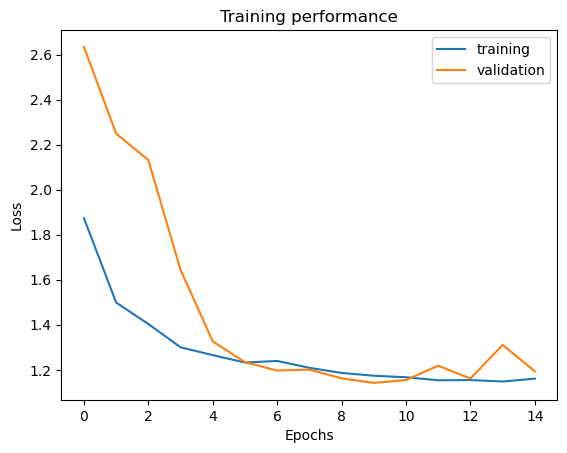

In [13]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

54/54 [==============================] - 3s 20ms/step


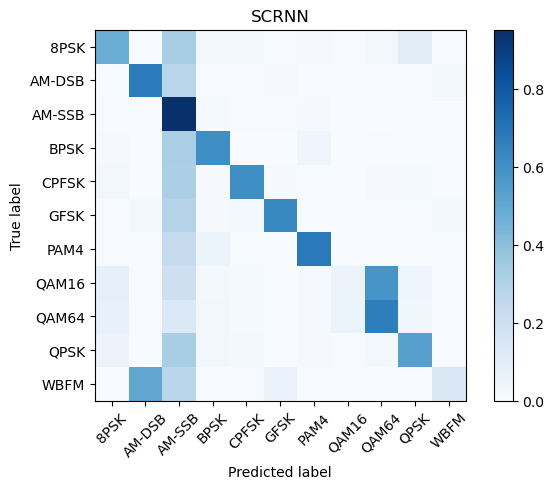

In [14]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

85/85 [==============================] - 2s 17ms/step
Overall Accuracy:  0.08283803863298662
85/85 [==============================] - 2s 18ms/step
Overall Accuracy:  0.09020332717190388
89/89 [==============================] - 2s 18ms/step
Overall Accuracy:  0.09367267585719335
89/89 [==============================] - 2s 19ms/step
Overall Accuracy:  0.10962754743499649
87/87 [==============================] - 1s 16ms/step
Overall Accuracy:  0.13800578034682082
88/88 [==============================] - 2s 17ms/step
Overall Accuracy:  0.20121732903687792
88/88 [==============================] - 2s 18ms/step
Overall Accuracy:  0.32210677176639196
86/86 [==============================] - 2s 20ms/step
Overall Accuracy:  0.48183139534883723
89/89 [==============================] - 2s 18ms/step
Overall Accuracy:  0.615193468228612
87/87 [==============================] - 2s 18ms/step
Overall Accuracy:  0.7304097771387491
87/87 [==============================] - 1s 16ms/step
Overall Accuracy:  

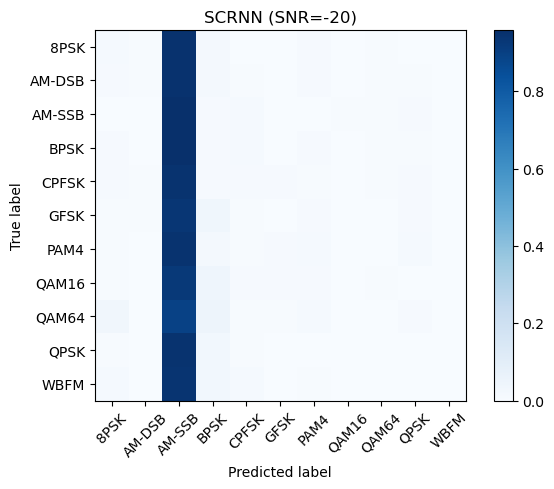

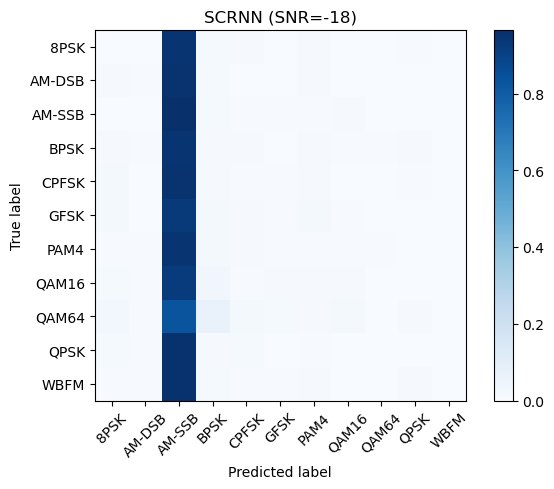

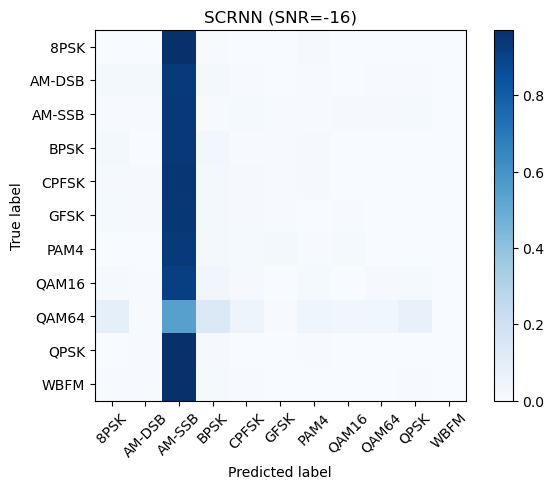

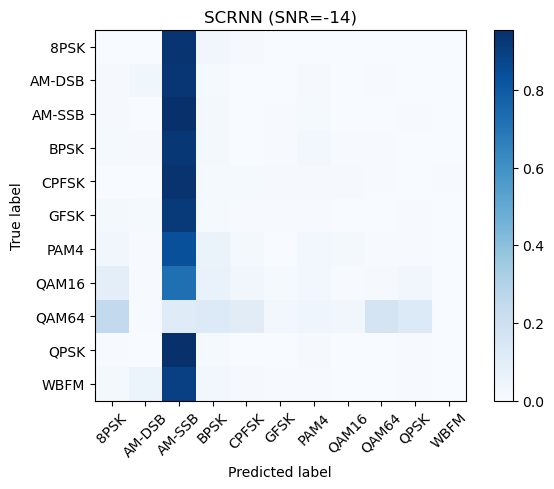

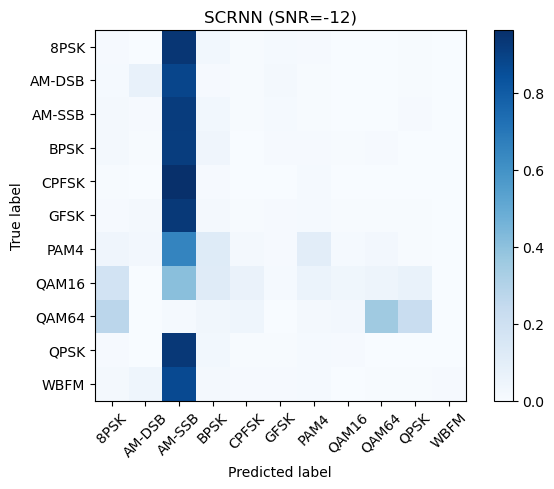

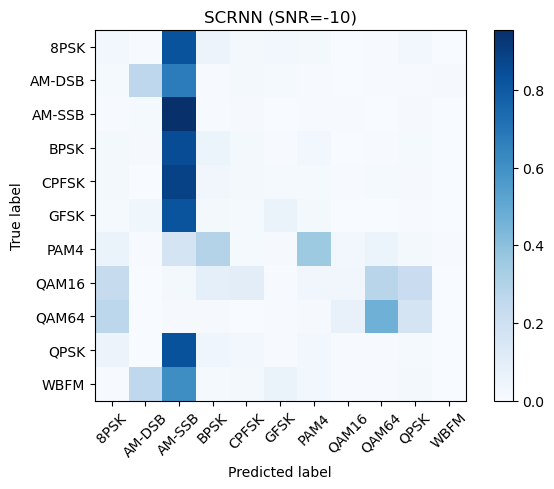

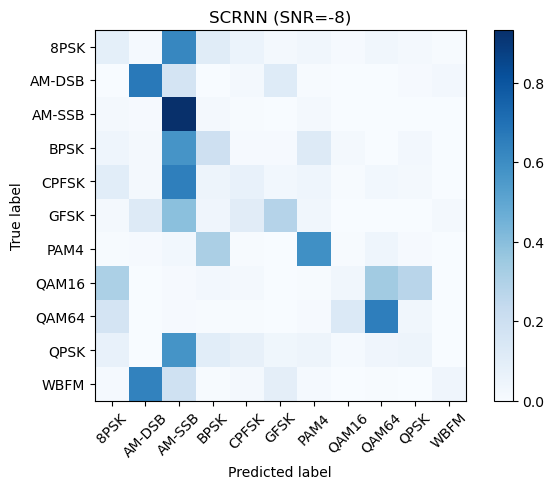

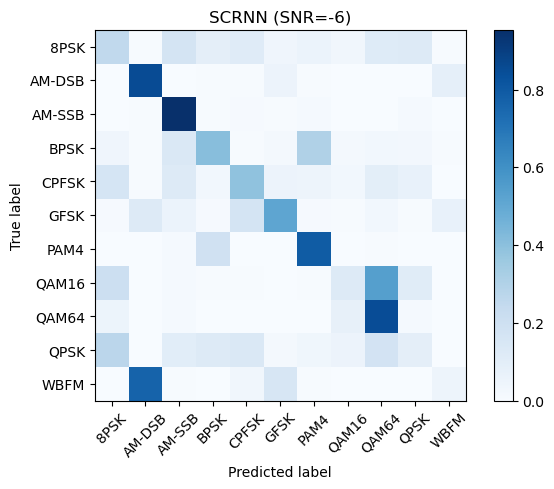

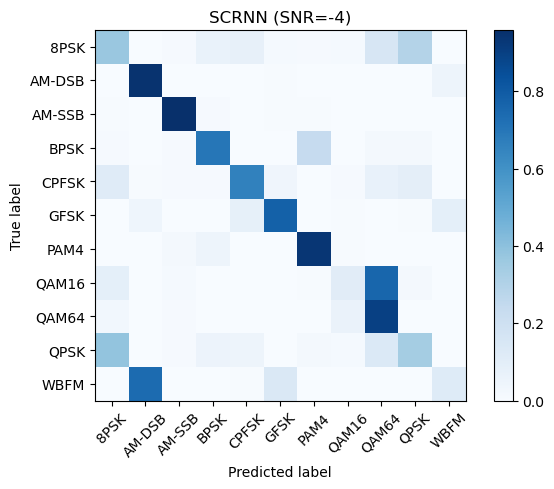

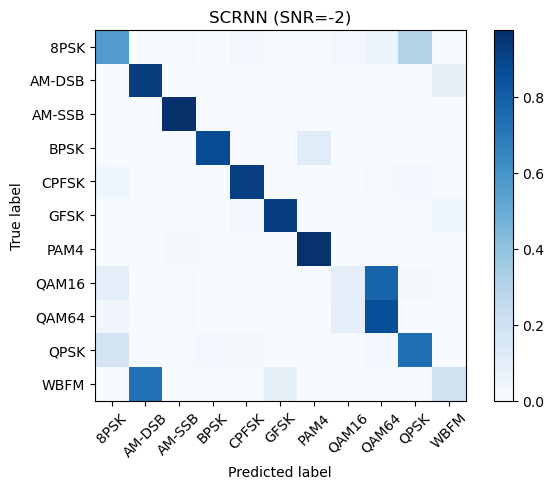

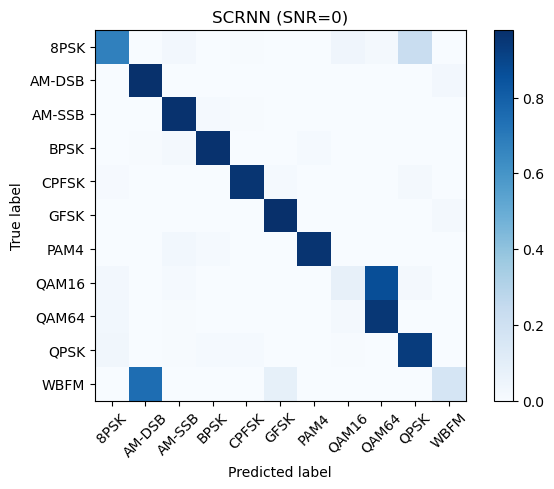

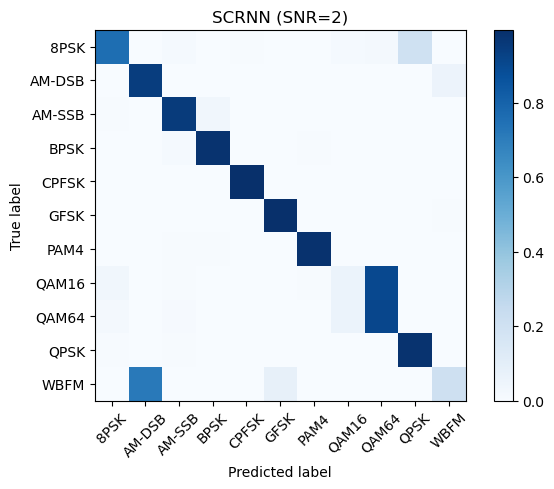

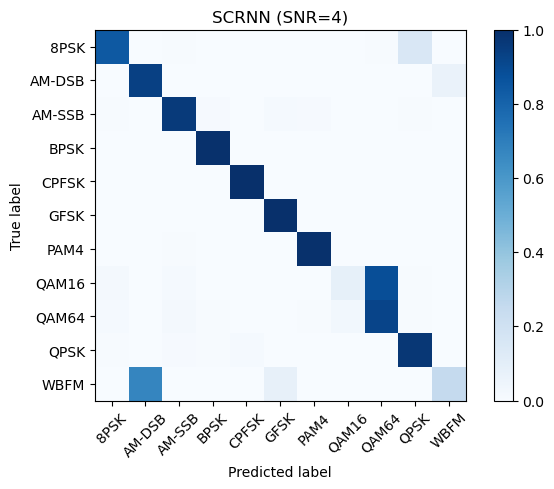

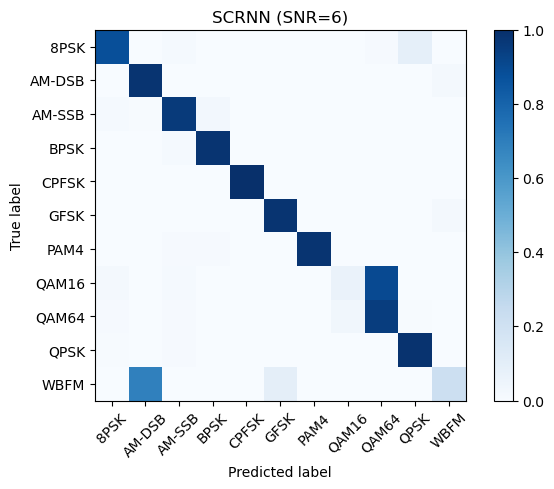

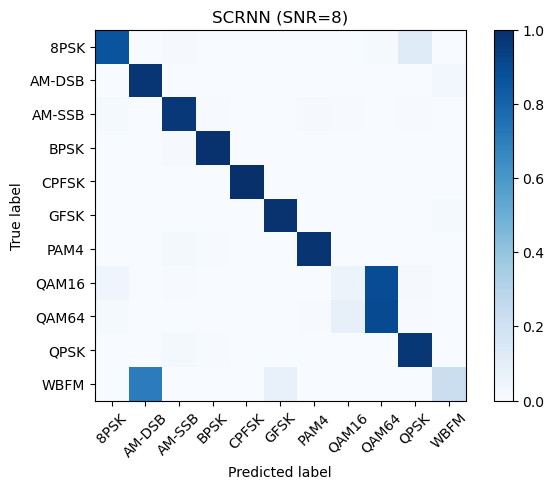

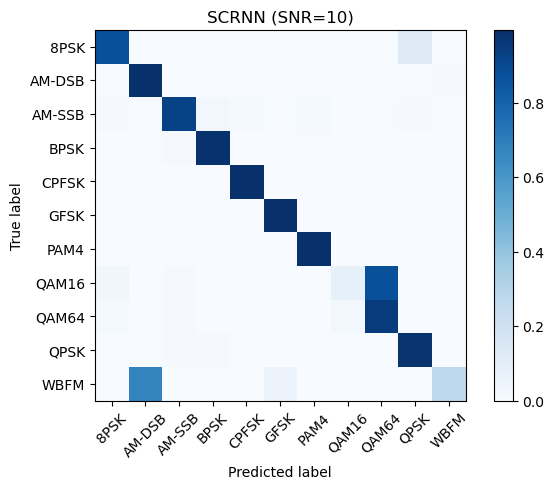

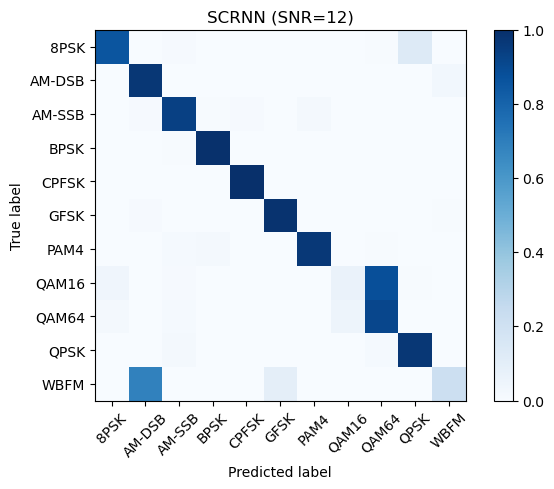

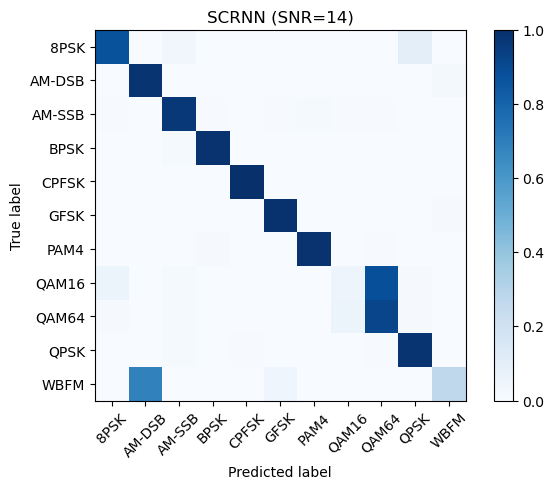

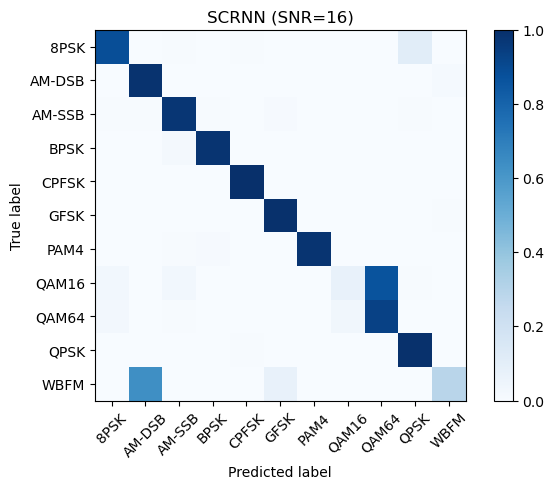

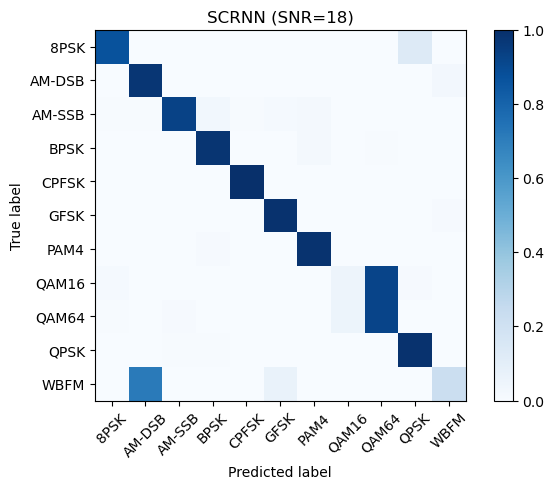

In [15]:
X_test = X_test.numpy() if hasattr(X_test, 'numpy') else X_test
Y_test = Y_test.numpy() if hasattr(Y_test, 'numpy') else Y_test

acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [16]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,13,20,32,48,61,73,78,79,81,82,81,82,81,81,83,80


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )
# Save results to a pickle file for plotting later
import pickle

with open("SCRNN_IQ_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
    
OUTPUT_FILENAME = 'SCRNN_IQ_acc.pkl'
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("SCRNN_IQ", acc) , fd )

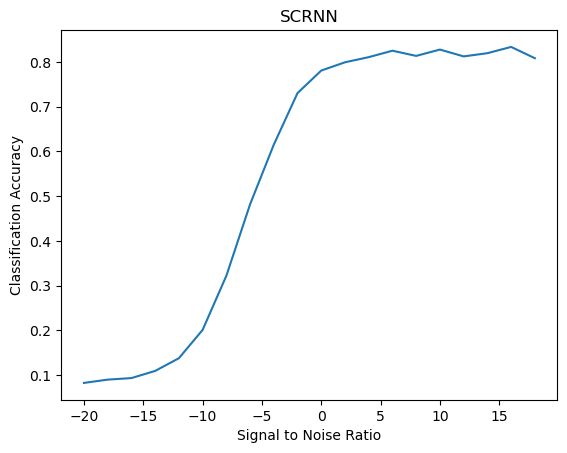

In [18]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)